In [1]:
from fastai import *
from fastai.vision import *

%matplotlib inline

PATH = os.path.abspath('..')

seed = 12345

In [2]:
sys.path.append(f'{PATH}/src')

from mxresnet import *
from ranger import Ranger

Mish activation loaded...
Mish activation loaded...


# Train

In [15]:
%run -i {PATH}/src/train_alfalfa.py --lr=3e-2 --bs=32 --n_epochs=100 --model=mxresnet50 \
    --seed={seed} --precision=full --catalog=fgas --save="best_xGASS-A-18"

Loaded `fgas` catalog of length 7399


epoch,train_loss,valid_loss,time
0,0.376156,0.516065,00:49
1,0.319057,0.306195,00:49
2,0.301711,0.327617,00:49
3,0.302579,0.299040,00:49
4,0.304451,0.281130,00:50
5,0.310809,0.316964,00:50
6,0.292792,0.284662,00:49
7,0.296594,0.279978,00:49
8,0.290332,0.471520,00:49
9,0.293898,0.272721,00:49


Better model found at epoch 0 with valid_loss value: 0.5160653591156006.
Better model found at epoch 1 with valid_loss value: 0.3061952292919159.
Better model found at epoch 3 with valid_loss value: 0.29904040694236755.
Better model found at epoch 4 with valid_loss value: 0.2811303436756134.
Better model found at epoch 7 with valid_loss value: 0.27997785806655884.
Better model found at epoch 9 with valid_loss value: 0.27272069454193115.
Better model found at epoch 43 with valid_loss value: 0.2564498484134674.
Better model found at epoch 48 with valid_loss value: 0.25357380509376526.
Better model found at epoch 53 with valid_loss value: 0.2515740692615509.
Better model found at epoch 59 with valid_loss value: 0.24861404299736023.
Better model found at epoch 63 with valid_loss value: 0.24849797785282135.
Better model found at epoch 72 with valid_loss value: 0.24536621570587158.
Better model found at epoch 77 with valid_loss value: 0.24199603497982025.
set state called


The best model is saved in `{PATH}/models/best_a40.pth`, unless another filename has been specified.

## Experimental results
    
    Results (all_properties = False; 7399)
                                           Val loss    TTA loss
      n_epoch  max_lr  precision   arch    --------    --------
        100     3e-2     mixed      34       0.240       0.246 
        100     3e-2     full       34       0.242       0.250
         40     3e-2     full       34       0.241       0.248
         
        100     3e-2     full       50       0.242       0.248
        
        
    Results (all_properties = True; 4797)
    
         40     5e-2     full       34       0.241       0.249
         40     3e-2     full       34       0.239       0.245
         40     1e-2     full       34       0.242       0.250
         40     3e-2     full       50       0.240       0.246

        

Note: mixed precision is great on NVidia T4 cards (available on Colab), but it's actually slower than 32-bit floats when using P100s!


    Training + validation time per epoch (`fgas` catalog)
    
                       P100 `fgas` `all`
                       ==== ------ -----
    Mixed precision          0:51   0:31
    Full precision           0:50   0:29

# Evaluate

In [16]:
learn.to_fp32();

In [17]:
fgas_pred, fgas_true = learn.TTA(scale=1.)
root_mean_squared_error(fgas_pred, fgas_true)

tensor(0.2481)

# Plot

In [8]:
results = pd.DataFrame({'fgas_pred': fgas_pred.squeeze(), 'fgas_true': fgas_true.squeeze()})
results['AGCNr'] = np.array([os.path.basename(fn).strip('.jpg') for fn in data.valid_ds.items])
results.set_index('AGCNr', drop=True, inplace=True)


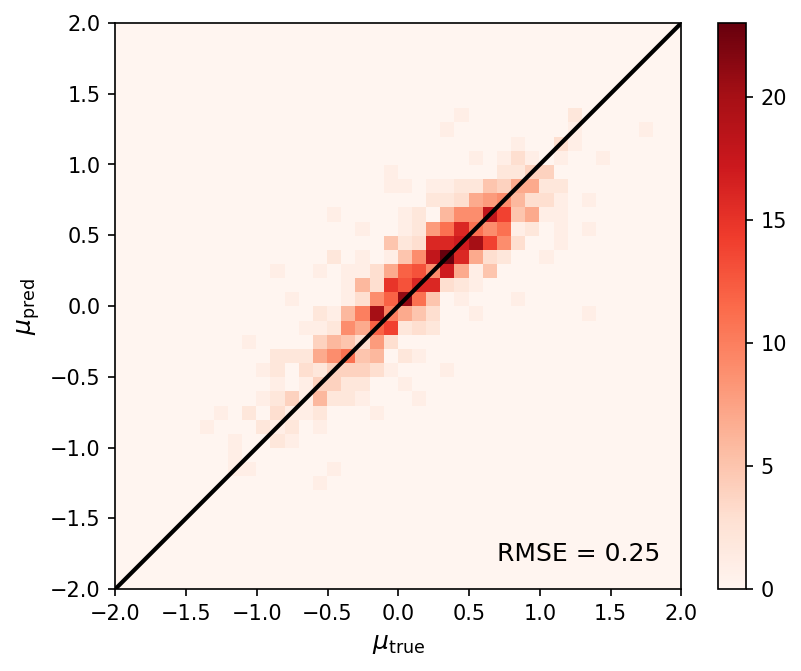

In [13]:
plt.figure(figsize=(6.2, 5), dpi=150)
plt.hist2d(results.fgas_true, results.fgas_pred, cmap='Reds', range=[(-2, 2), (-2, 2)], bins=40);
plt.plot([-2, 2], [-2, 2], c='black', ls='-', lw=2)
plt.gca().set_aspect('equal')
plt.colorbar();
plt.xlabel(r'$\mu_{\rm true}$', fontsize=12)
plt.ylabel(r'$\mu_{\rm pred}$', fontsize=12);
plt.xticks(np.arange(-2, 2.5, .5))
plt.yticks(np.arange(-2, 2.5, .5));

plt.text(0.7, -1.8, f'RMSE = {root_mean_squared_error(fgas_pred, fgas_true):.2f}', fontsize=12);

# terrible terrible way to determine which catalog we're using
catalog_id = "B" if len(df) == 4797 else "A"
plt.savefig(f'{PATH}/results/figures/results-hist_a40{catalog_id}')